In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch

import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset

In [2]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-32f0d354-d4b5-5535-3054-6b7e4690bf35)


In [0]:
class PrintLayer(nn.Module):
    def __init__(self, name=''):
        super().__init__()
        self.name = name

    def forward(self, x):
        print(self.name, x.shape)
        return x


class CNN_1(nn.Module):
    """
    The CNN architecture for working with LOB dataset proposed in the paper
    Forecasting Stock Prices from the Limit Order Book using Convolutional Neural Networks
    """
    def __init__(self, input_cnn=1, n_filters_1=16, n_filters_2=32, depth=100):
        """
        input_cnn: number of input channels 
        n_filters_1: number of filters in 2D convolutions
        n_filters_2: number of filters in 1D convolutions
        depth: vertical shape of input matrix X = [X_0, X_1, ..., X_100]^T
        
        input size is (16, 1, 100, 40)
        """
        super().__init__()
            
        self.conv_block_2d = nn.Sequential(
            nn.ZeroPad2d((0,0,2,1)),                               # (16, 1, 103, 40)
            nn.Conv2d(input_cnn, n_filters_1, kernel_size=(4,40)), # (16, 16, 100, 1)
            nn.LeakyReLU(),)
        self.conv_block_1d = nn.Sequential(
            nn.ConstantPad1d((2, 1), 0),                           # (16, 16, 103)
            )
        self.conv_block_1d_proceed = nn.Sequential(
            nn.Conv1d(n_filters_1, n_filters_1, kernel_size=(4,)), # (16, 16, 100)
            nn.LeakyReLU(),
            nn.ConstantPad1d((1, 0), 0),                           # (16, 16, 101)
            nn.MaxPool1d(kernel_size=(2,), stride=(1,)),           # (16, 16, 100)
            nn.Conv1d(n_filters_1, n_filters_2, kernel_size=(3,), padding=1), # (16, 32, 100)
            nn.LeakyReLU(),
            nn.Conv1d(n_filters_2, n_filters_2, kernel_size=(3,), padding=1), # (16, 32, 100)
            nn.LeakyReLU(),
            nn.ConstantPad1d((1, 0), 0),                           # (16, 16, 101)
            nn.MaxPool1d(kernel_size=(2,), stride=(1,)),           # (16, 32, 100)
            )
        
        self.fc = nn.Linear(n_filters_2*depth, 3)                  # (16, 3)

    def reset_hidden_state(self):
        """
        just for the code integrity, nedeed in LSTM
        """
        pass

    def forward(self, x):
        x = self.conv_block_2d(x).squeeze(3)
        x = self.conv_block_1d(x)
        x = self.conv_block_1d_proceed(x)

        x = x.view(-1, x.shape[1]*x.shape[2])
        out = self.fc(x)

        return out

In [0]:
class LSTM(nn.Module):
    """
    The LSTM architecture for working with LOB dataset proposed in the paper
    'Using Deep Learning to Detect Price Change Indications in Financial Markets'
    in Signal Processing Conference (EUSIPCO), 2017 25th European. IEEE, 2017, pp. 2511–2515.
    """
    def __init__(self, input_dim=40, hidden_dim=40, seq_len=100, num_class=3, num_layers=2):
        """
        input shape is (seq_len, batch, input_size)

        input_dim: The number of expected features in the input (in our case 40)
        hidden_dim: The number of features in the hidden state h
        seq_len: length of sequence (100 in our case)
        num_class: number of predicting classes (output dim of NN)
        """
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.num_layers = num_layers
 
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, 
                            self.num_layers, dropout=0.2)
 
        self.linear = nn.Sequential(
            nn.Linear(self.hidden_dim, num_class),
            nn.LeakyReLU()
        )
        self.apply(self.weights_init)
    
    def weights_init(self, m):
        for name, param in m.named_parameters():
            if 'bias_ih' in name:
                nn.init.zeros_(param)
            elif 'bias_hh' in name:
                nn.init.zeros_(param)
            elif 'weight_ih' in name:
                nn.init.xavier_uniform_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
        
    def forward(self, sequences):
        lstm_out, _ = self.lstm(sequences.view(len(sequences), 
                                                        self.seq_len, -1))
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.hidden_dim)[-1]
        y_pred = self.linear(last_time_step)
        
        return y_pred

In [5]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [0]:
from sklearn.metrics import f1_score, recall_score, precision_score

def metrics_score(true, pred):
    """
    The function calculates the metrics: f1, recall, precision
    It used inside training function
    
    true: true labels
    predict: predict labels
    """
    pred_class = torch.argmax(pred, dim=1, keepdim=False)

    pred_class = pred_class.cpu().detach().numpy()
    true = true.cpu().detach().numpy()

    f1 = f1_score(true, pred_class, average='macro')
    recall = recall_score(true, pred_class, average='macro')
    precision = precision_score(true, pred_class, average='macro')

    return f1, recall, precision

In [0]:
def run_epoch(model, optimizer, criterion, dataloader, epoch, mode='train', device=DEVICE):
    """
    The function which deals with epoch running
    """
    if mode=='train':
        model.train()
    else:
        model.eval()
    epoch_loss = 0.0
    # f1_overall, rec_overall, prec_overall = 0.0, 0.0, 0.0
    for i, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        iteration_n = epoch * i + i
        # model.hidden = model.reset_hidden_state()
        y_pred = model(X)

        loss = criterion(y_pred, y)
        
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss += loss.item()

        # f1, recall, precision = metrics_score(y, y_pred)
        # f1_overall += f1
        # rec_overall += recall
        # prec_overall += precision
    
    return epoch_loss / len(dataloader)#, f1_overall / len(dataloader), \
            # rec_overall / len(dataloader), prec_overall / len(dataloader)

In [0]:
from collections import defaultdict

def train(model, optimizer, criterion, train_loader, val_loader, n_epochs,
          scheduler=None, checkpoint=True, early_stopping=False, es_patience=10, freq=None, verbose=True):
    """
    main training function
    It return the trained model and results dictionary with all stats collected while training
    loss values and metrics defined in metrics_score function
    """
    if verbose and freq is None:
        freq = max(1, n_epochs // 10)

    best_val_loss = float('+inf')
    bad_epochs = 0
    results = defaultdict(list)
    
    for epoch in range(n_epochs):
        train_loss = run_epoch(model, optimizer, criterion, train_loader, epoch, 'train')
        val_loss = run_epoch(model, None, criterion, val_loader, epoch, 'val')
        # train_loss, f1_train, rec_train, prec_train = run_epoch(model, optimizer, criterion, train_loader, epoch, 'train')
        # val_loss, f1_val, rec_val, prec_val = run_epoch(model, None, criterion, val_loader, epoch, 'val')
        
        results['train_loss'].append(train_loss)
        # results['f1_train'].append(f1_train)
        # results['rec_train'].append(rec_train)
        # results['prec_train'].append(prec_train)
        results['val_loss'].append(val_loss)
        # results['f1_val'].append(f1_val)
        # results['rec_val'].append(rec_val)
        # results['prec_val'].append(prec_val)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            
            if checkpoint:
                torch.save(model.state_dict(), './model_best_20days_pred.pth')
        
        if scheduler is not None:
            scheduler.step(val_loss)
        if verbose and epoch % freq == 0:
            print("Epoch {}: train loss - {} | validation loss - {}".format(epoch, train_loss, val_loss))
            # print(f'\t f1_val={round(f1_val, 3)}, rec_val={round(rec_val, 3)}, prec_val={round(prec_val, 3)}')
        
        if early_stopping:
            bad_epochs += 1
            if bad_epochs > es_patience:
                print("Stopped at", epoch, "because patience threshold for epochs",\
                      "without validation loss improvement was reached.")
                break

    return model, results

In [0]:
def plot_save_results(results, length_fore):
    """
    results: dict with history of train and validation losses and accuracies
    length_fore: number of days in the future the forecast is made
    """
    length = len(results['train_loss'])

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
    
    axes[0].plot(list(range(1, length+1)), results['train_loss'], label='train loss')
    axes[0].plot(list(range(1, length+1)), results['val_loss'], label='validation loss')

    axes[1].plot(list(range(1, length+1)), results['f1_val'], label='f1')
    axes[1].plot(list(range(1, length+1)), results['rec_val'], label='recall')
    axes[1].plot(list(range(1, length+1)), results['prec_val'], label='precision')

    axes[0].legend(fontsize=12)
    axes[1].legend(fontsize=12)

    axes[0].set_xlabel('epocs #', fontsize=15)
    axes[1].set_xlabel('epocs #', fontsize=15)

    axes[0].set_title(f'Loss, forecast length {length_fore}', fontsize=15)
    axes[1].set_title(f'Metrics on validation, forecast length {length_fore}', fontsize=15);

    plt.savefig(f'stats, fore_len_{length_fore}.png')

# LOB dataset

In [0]:
import torch
import random

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Load data


In [0]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False


if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = "/content/drive/My Drive/FI2010"
    
else:
    AUX_DATA_ROOT = './FI-2010'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os

train_data = np.load(os.path.join(AUX_DATA_ROOT, 'train_data.npy'))
val_data = np.load(os.path.join(AUX_DATA_ROOT, 'val_data.npy'))
test_data = np.load(os.path.join(AUX_DATA_ROOT, 'test_data.npy'))
train_labels = np.load(os.path.join(AUX_DATA_ROOT, 'train_labels.npy'))
val_labels = np.load(os.path.join(AUX_DATA_ROOT, 'val_labels.npy'))
test_labels = np.load(os.path.join(AUX_DATA_ROOT, 'test_labels.npy'))

In [0]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(254750, 40)
(107650, 40)
(31937, 40)


In [0]:
class FI_Dataset_CNN(Dataset):
    
    def __init__(self, X, y, T, target_num=0):
        self.T = T
        self.X = torch.from_numpy(X).unsqueeze(0).float()
        self.y = torch.from_numpy(y[T - 1:, target_num]).long() - 1
    
    def __len__(self):
        return len(self.X[0]) - self.T
    
    def __getitem__(self, idx):
        return self.X[:, idx:idx+self.T], self.y[idx]


class FI_Dataset_LSTM(Dataset):
    
    def __init__(self, X, y, T, target_num=0):
        self.T = T
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y[T - 1:, target_num]).long() - 1
    
    def __len__(self):
        return len(self.X) - self.T
    
    def __getitem__(self, idx):
        return self.X[idx:idx+self.T], self.y[idx]

In [0]:
MODEL_TYPE = 'LSTM' # set the model type. Possible variants are 'LSTM' and 'CNN'

In [0]:
if MODEL_TYPE=='LSTM':
    train_dataset = FI_Dataset_LSTM(train_data, train_labels, T=100, target_num=4)
    val_dataset = FI_Dataset_LSTM(val_data, val_labels, T=100, target_num=4)
    test_dataset = FI_Dataset_LSTM(test_data, test_labels, T=100, target_num=4)
elif MODEL_TYPE=='CNN':
    train_dataset = FI_Dataset_CNN(train_data, train_labels, T=100, target_num=0)
    val_dataset = FI_Dataset_CNN(val_data, val_labels, T=100, target_num=0)
    test_dataset = FI_Dataset_CNN(test_data, test_labels, T=100, target_num=0)
else:
    print('Such architecture have not been implemented yet')
    raise SystemExit


TRAIN_BATCH_SIZE = 16
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

VAL_BATCH_SIZE = 16
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=True)

TEST_BATCH_SIZE = 16
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

In [0]:
for i, (X,y) in enumerate(train_loader):
    print(X.shape, y.shape)
    break

torch.Size([16, 100, 40]) torch.Size([16])


### Train

In [0]:
LR = 0.001
N_EPOCS = 20

if MODEL_TYPE=='LSTM':
    print('Training LSTM')
    model = LSTM(input_dim=40, hidden_dim=40, seq_len=100, num_class=3, num_layers=2).to(DEVICE)
elif MODEL_TYPE=='CNN':
    print('Training CNN')
    model = CNN_1(input_cnn=1, n_filters_1=16, n_filters_2=32, depth=100).to(DEVICE)
else:
    print('Such architecture have not been implemented yet')
    raise SystemExit


optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

Training LSTM


In [0]:
model, results = train(model, optimizer, criterion, train_loader, val_loader, N_EPOCS,
                        scheduler=None, checkpoint=True, early_stopping=True, 
                        es_patience=10, freq=None, verbose=True)

Epoch 0: train loss - 1.051334697233579 | validation loss - 1.1837323649551712
Epoch 2: train loss - 1.0508221802129671 | validation loss - 1.1750583583065102
Epoch 4: train loss - 1.050440580222019 | validation loss - 1.1680600984807314
Epoch 6: train loss - 1.0503756520053975 | validation loss - 1.1593889632649947
Epoch 8: train loss - 1.0500498718504152 | validation loss - 1.166270247929084
Epoch 10: train loss - 1.0501474826464434 | validation loss - 1.169712005476269
Epoch 12: train loss - 1.0500793771157764 | validation loss - 1.1795292073986567
Epoch 14: train loss - 1.0499267635347855 | validation loss - 1.1723647214354804
Epoch 16: train loss - 1.0496365414451612 | validation loss - 1.170971362834103
Epoch 18: train loss - 1.049419739443952 | validation loss - 1.1667329096184071


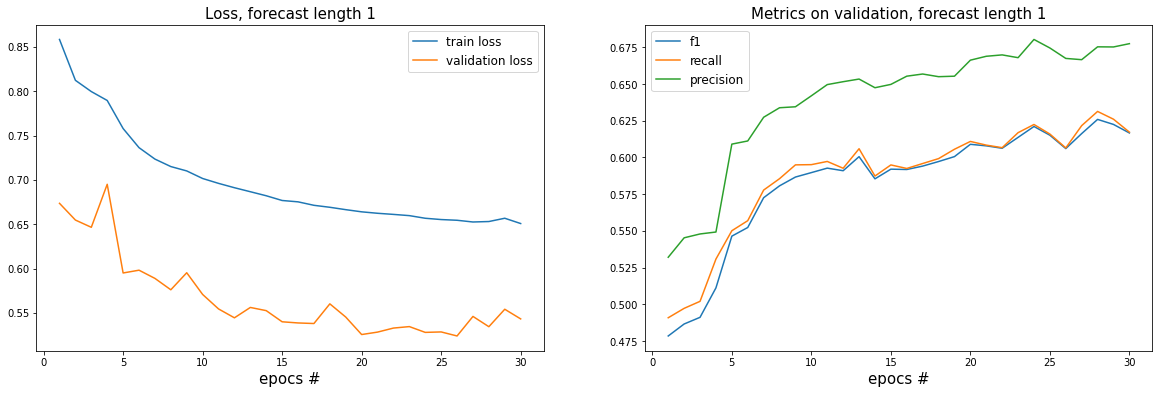

In [0]:
plot_save_results(results, length_fore=10) 

### Predict

In [0]:
if MODEL_TYPE=='LSTM':
    print('Training LSTM')
    model_test = LSTM(input_dim=40, hidden_dim=40, seq_len=100, num_class=3, num_layers=2).to(DEVICE)
elif MODEL_TYPE=='CNN':
    print('Training CNN')
    model_test = CNN_1(input_cnn=1, n_filters_1=16, n_filters_2=32, depth=100).to(DEVICE)
else:
    print('Such architecture have not been implemented yet')
    raise SystemExit
    
PATH = './model_best_10days_pred.pth'
model_test.load_state_dict(torch.load(PATH))
model_test.eval()

Training LSTM


LSTM(
  (lstm): LSTM(40, 40, num_layers=2, dropout=0.2)
  (linear): Sequential(
    (0): Linear(in_features=40, out_features=3, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
)

In [0]:
# make predicitions on the test set usinf weights obtained wile training.
# as a result we get y_pred_list - list of our test prediction
# y_true_list - list of real values

y_pred_list = []
y_true_list = []
# model.eval()
with torch.no_grad():
    for i, (X_batch, y_batch) in enumerate(test_loader):
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        y_test_pred = model_test(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)

        y_pred_class = torch.argmax(y_test_pred, dim=1)
        y_pred_list.append(y_pred_class.cpu().numpy())

        y_true_list.append(y_batch.cpu().numpy())


y_pred_list = [a.tolist() for a in y_pred_list]
y_pred_list = np.concatenate([np.reshape(y_pred_list[:-1], (-1)), y_pred_list[-1]])

y_true_list = [a.tolist() for a in y_true_list]
y_true_list = np.concatenate([np.reshape(y_true_list[:-1], (-1)), y_true_list[-1]])

In [0]:
# calculating metrics, compounding them into df and saving to Excel

f1 = round(f1_score(y_true_list, y_pred_list, average='macro')*100, 2)
recall = round(recall_score(y_true_list, y_pred_list, average='macro')*100, 2)
precision = round(precision_score(y_true_list, y_pred_list, average='macro')*100, 2)
accuracy = round((y_true_list == y_pred_list).mean()*100, 2)

res = pd.DataFrame(columns=['f1', 'recall', 'precision', 'accuracy'])
res.loc[0] = [f1, recall, precision, accuracy]
res.to_excel('LSTM_LOB_predict10days.xlsx', index=False)
res

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,f1,recall,precision,accuracy
0,18.63,33.32,25.12,38.31


# Crypto dataset

### Load Data

In [11]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False


if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = "/content/drive/My Drive/Processed_datatsets"
    
else:
    AUX_DATA_ROOT = './crypto_data'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os

data_1 = np.load(os.path.join(AUX_DATA_ROOT, 'input_LTCUSDT_1.npy'))
labels_1 = np.load(os.path.join(AUX_DATA_ROOT, 'labels_LTCUSDT_1.npy'))
data_5 = np.load(os.path.join(AUX_DATA_ROOT, 'input_LTCUSDT_5.npy'))
labels_5 = np.load(os.path.join(AUX_DATA_ROOT, 'labels_LTCUSDT_5.npy'))
data_10 = np.load(os.path.join(AUX_DATA_ROOT, 'input_LTCUSDT_10.npy'))
labels_10 = np.load(os.path.join(AUX_DATA_ROOT, 'labels_LTCUSDT_10.npy'))


data_20 = np.load(os.path.join(AUX_DATA_ROOT, 'input_BTCUSDT_5_20.npy'))
labels_20 = np.load(os.path.join(AUX_DATA_ROOT, 'labels_BTCUSDT_5_20.npy'))

In [0]:
# custom datasets for DataLoader separate for CNN and LSTM training

class Crypto_Dataset(Dataset):
    
    def __init__(self, X, y, T):
        self.T = T
        self.X = torch.from_numpy(X).unsqueeze(0).float()
        self.y = torch.from_numpy(y[T - 1:]).long() - 1
    
    def __len__(self):
        return len(self.X[0]) - self.T
    
    def __getitem__(self, idx):
        return self.X[:, idx:idx+self.T], self.y[idx]

class Crypto_Dataset_LSTM(Dataset):
    
    def __init__(self, X, y, T):
        self.T = T
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y[T - 1:]).long() - 1
    
    def __len__(self):
        return len(self.X) - self.T
    
    def __getitem__(self, idx):
        return self.X[idx:idx+self.T], self.y[idx]

In [0]:
# custom train test split, suitable for time series

def train_test_split_(data, labels):
    lim_tr = int(data.shape[0]*0.7) # 70% for train
    lim_val = int(data.shape[0]*0.85) # 15% for val and 15% for test

    X_train, X_val, X_test = data[:lim_tr], data[lim_tr:lim_val], data[lim_val:]
    y_train, y_val, y_test = labels[:lim_tr], labels[lim_tr:lim_val], labels[lim_val:]

    return X_train, X_val, X_test, y_train, y_val, y_test

### Train

In [0]:
MODEL_TYPE = 'CNN'

In [0]:
train_data, val_data, test_data, train_labels, val_labels, test_labels = train_test_split_(data_20, labels_20)

if MODEL_TYPE=='LSTM':
    train_dataset = Crypto_Dataset_LSTM(train_data, train_labels, T=60)
    val_dataset = Crypto_Dataset_LSTM(val_data, val_labels, T=60)
    test_dataset = Crypto_Dataset_LSTM(test_data, test_labels, T=60)
elif MODEL_TYPE=='CNN':
    train_dataset = Crypto_Dataset(train_data, train_labels, T=60)
    val_dataset = Crypto_Dataset(val_data, val_labels, T=60)
    test_dataset = Crypto_Dataset(test_data, test_labels, T=60)
else:
    print('Such architecture have not been implemented yet')
    raise SystemExit


TRAIN_BATCH_SIZE = 16
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

VAL_BATCH_SIZE = 16
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=True)

TEST_BATCH_SIZE = 16
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

In [17]:
LR = 0.00001
N_EPOCS = 60

if MODEL_TYPE=='LSTM':
    print('Training LSTM')
    model = LSTM(input_dim=40, hidden_dim=40, seq_len=60, num_class=3, num_layers=2).to(DEVICE)
elif MODEL_TYPE=='CNN':
    print('Training CNN')
    model = CNN_1(input_cnn=1, n_filters_1=16, n_filters_2=32, depth=60).to(DEVICE)
else:
    print('Such architecture have not been implemented yet')
    raise SystemExit

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

Training CNN


In [18]:
model, results = train(model, optimizer, criterion, train_loader, val_loader, N_EPOCS,
                        scheduler=None, checkpoint=True, early_stopping=False, 
                        es_patience=20, freq=None, verbose=True)

Epoch 0: train loss - 1.0475321186135957 | validation loss - 1.0678151926512074
Epoch 6: train loss - 1.028580516839806 | validation loss - 1.0474399278407496
Epoch 12: train loss - 1.0086566985889756 | validation loss - 1.000163894352741
Epoch 18: train loss - 0.99980057032889 | validation loss - 1.0300791767974633
Epoch 24: train loss - 0.9910230342650561 | validation loss - 1.0040408063806767
Epoch 30: train loss - 0.9853868632193488 | validation loss - 1.0010552462001976
Epoch 36: train loss - 0.9810185661935638 | validation loss - 0.9754022871008599
Epoch 42: train loss - 0.9751528021595905 | validation loss - 0.939375496165145
Epoch 48: train loss - 0.9712824757422164 | validation loss - 1.0055526471605487
Epoch 54: train loss - 0.9687879489963284 | validation loss - 0.9643774426266382


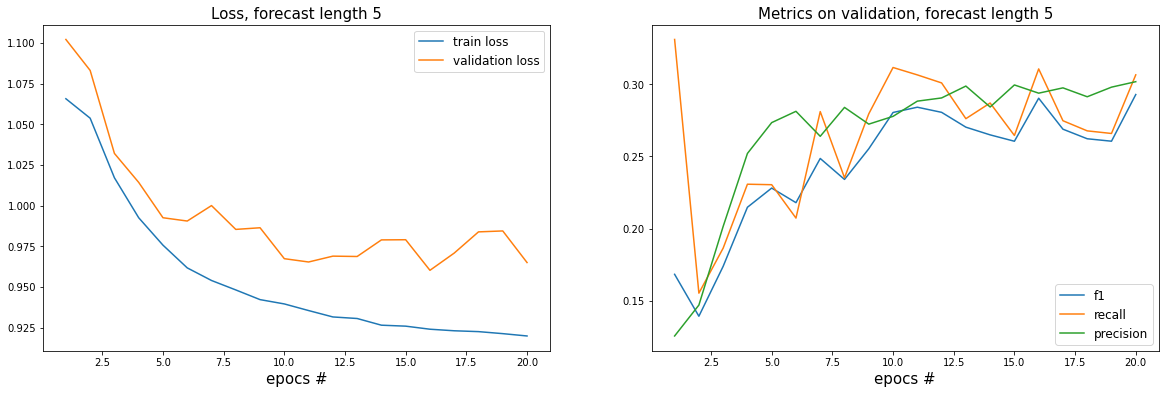

In [0]:
plot_save_results(results, length_fore=5)

### Predict

In [19]:
if MODEL_TYPE=='LSTM':
    print('Training LSTM')
    model_test = LSTM(input_dim=40, hidden_dim=40, seq_len=60, num_class=3, num_layers=2).to(DEVICE)
elif MODEL_TYPE=='CNN':
    print('Training CNN')
    model_test = CNN_1(input_cnn=1, n_filters_1=16, n_filters_2=32, depth=60).to(DEVICE)
else:
    print('Such architecture have not been implemented yet')
    raise SystemExit
    
    
PATH = './model_best_20days_pred.pth'
model_test.load_state_dict(torch.load(PATH))
model_test.eval()

Training CNN


CNN_1(
  (conv_block_2d): Sequential(
    (0): ZeroPad2d(padding=(0, 0, 2, 1), value=0.0)
    (1): Conv2d(1, 16, kernel_size=(4, 40), stride=(1, 1))
    (2): LeakyReLU(negative_slope=0.01)
  )
  (conv_block_1d): Sequential(
    (0): ConstantPad1d(padding=(2, 1), value=0)
  )
  (conv_block_1d_proceed): Sequential(
    (0): Conv1d(16, 16, kernel_size=(4,), stride=(1,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConstantPad1d(padding=(1, 0), value=0)
    (3): MaxPool1d(kernel_size=(2,), stride=(1,), padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): LeakyReLU(negative_slope=0.01)
    (8): ConstantPad1d(padding=(1, 0), value=0)
    (9): MaxPool1d(kernel_size=(2,), stride=(1,), padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1920, out_features=3, bias=True)
)

In [0]:
# make predicitions on the test set usinf weights obtained wile training.
# as a result we get y_pred_list - list of our test prediction
# y_true_list - list of real values

y_pred_list = []
y_true_list = []
# model.eval()
with torch.no_grad():
    for i, (X_batch, y_batch) in enumerate(test_loader):
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        y_test_pred = model_test(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)

        y_pred_class = torch.argmax(y_test_pred, dim=1)
        y_pred_list.append(y_pred_class.cpu().numpy())

        y_true_list.append(y_batch.cpu().numpy())


y_pred_list = [a.tolist() for a in y_pred_list]
y_pred_list = np.concatenate([np.reshape(y_pred_list[:-1], (-1)), y_pred_list[-1]])

y_true_list = [a.tolist() for a in y_true_list]
y_true_list = np.concatenate([np.reshape(y_true_list[:-1], (-1)), y_true_list[-1]])

In [21]:
# calculating metrics, compounding them into df and saving to Excel

f1 = round(f1_score(y_true_list, y_pred_list, average='macro')*100, 2)
recall = round(recall_score(y_true_list, y_pred_list, average='macro')*100, 2)
precision = round(precision_score(y_true_list, y_pred_list, average='macro')*100, 2)
accuracy = round((y_true_list == y_pred_list).mean()*100, 2)

res = pd.DataFrame(columns=['f1', 'recall', 'precision', 'accuracy'])
res.loc[0] = [f1, recall, precision, accuracy]
res.to_excel('LSTM_Crypto_predict20days.xlsx', index=False)
res

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,f1,recall,precision,accuracy
0,15.55,13.92,24.46,20.04
